# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [2]:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn.preprocessing import RobustScaler
from sklearn import tree
import plotly.express as px
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [3]:
churn_data = pd.read_csv('ML-3_churn/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

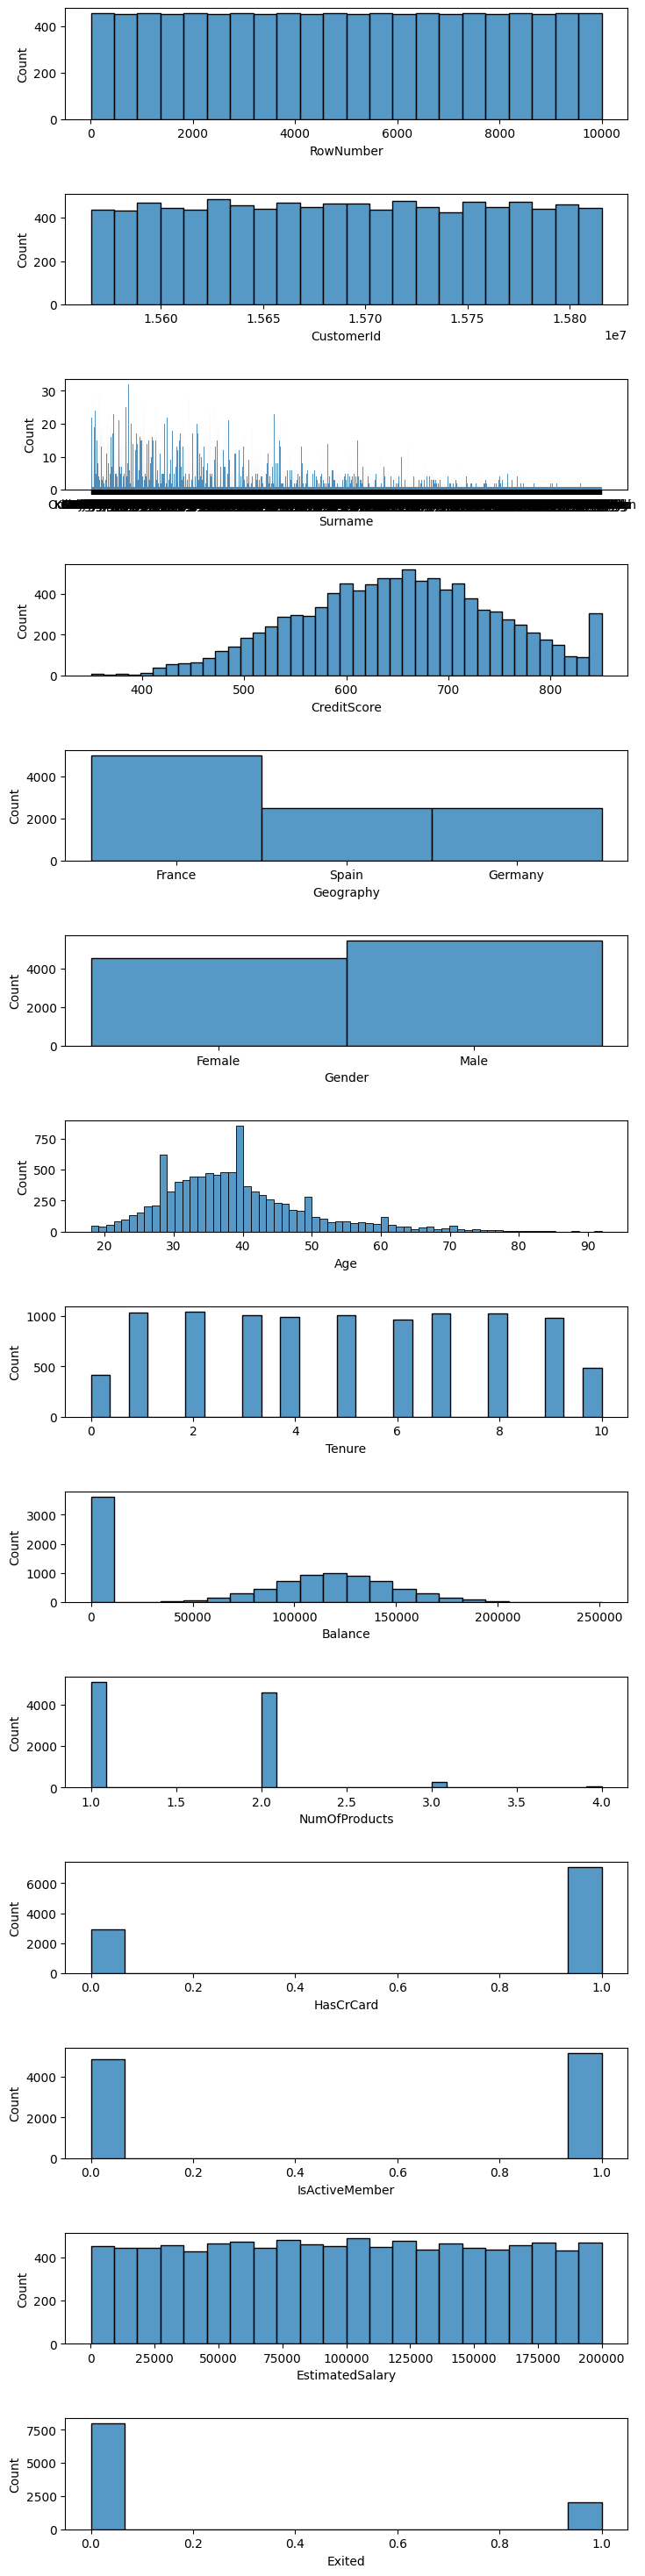

In [4]:
'''посмотрим на распределение признаков
не имеет сымсл строить графики связи признаков с целевой переменной т.к. целевая перемеенная имеет только 2 значения
т.е. при одном и том же значении признака целевая переменная может иметь разные значения.Это малоинформативно.'''

#код для графиков
fig, ax1=plt.subplots(len(churn_data.columns), figsize=(8,30))

for  i,feature in enumerate(churn_data.columns):
    histplot=sns.histplot(data=churn_data,x=feature,ax=ax1[i])
    
fig.tight_layout(pad=3.0)   
plt.show() 

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [5]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        2509 non-null   int64  
 1   CustomerId       2509 non-null   int64  
 2   Surname          2509 non-null   object 
 3   CreditScore      2509 non-null   int64  
 4   Geography        2509 non-null   object 
 5   Gender           2509 non-null   object 
 6   Age              2509 non-null   int64  
 7   Tenure           2509 non-null   int64  
 8   Balance          2509 non-null   float64
 9   NumOfProducts    2509 non-null   int64  
 10  HasCrCard        2509 non-null   int64  
 11  IsActiveMember   2509 non-null   int64  
 12  EstimatedSalary  2509 non-null   float64
 13  Exited           2509 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 294.0+ KB


Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [6]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [7]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [8]:
churn_data[churn_data.duplicated()].sum()
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2509 non-null   int64  
 1   Gender           2509 non-null   object 
 2   Age              2509 non-null   int64  
 3   Tenure           2509 non-null   int64  
 4   Balance          2509 non-null   float64
 5   NumOfProducts    2509 non-null   int64  
 6   HasCrCard        2509 non-null   int64  
 7   IsActiveMember   2509 non-null   int64  
 8   EstimatedSalary  2509 non-null   float64
 9   Exited           2509 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 215.6+ KB


### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [9]:
#создаем признаки
churn_data['BalanceSalaryRatio']=round(churn_data['Balance']/churn_data['EstimatedSalary'],2)
churn_data['TenureByAge']=round(churn_data['Tenure']/churn_data['Age'],2)
churn_data['CreditScoreGivenAge']=round(churn_data['CreditScore']/churn_data['Age'],2)

#выделяем и переводим категориальные признаки в бинарные
object_columns = [s for s in churn_data.columns if churn_data[s].dtypes == 'object']

churn_data=pd.get_dummies(churn_data,columns=object_columns)
print(churn_data.info())
#churn_data.drop(object_columns,axis=1,inplace=True)

#код для расчета основных статистичесих характеристик новых признаков.
#Фильтроовал по типу и поэтому отфильтровался также старый признак баланс, но в этом нет ничего страшного.
churn_data.describe(include=[np.float64])

# Ваш код здесь

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Age                  2509 non-null   int64  
 2   Tenure               2509 non-null   int64  
 3   Balance              2509 non-null   float64
 4   NumOfProducts        2509 non-null   int64  
 5   HasCrCard            2509 non-null   int64  
 6   IsActiveMember       2509 non-null   int64  
 7   EstimatedSalary      2509 non-null   float64
 8   Exited               2509 non-null   int64  
 9   BalanceSalaryRatio   2509 non-null   float64
 10  TenureByAge          2509 non-null   float64
 11  CreditScoreGivenAge  2509 non-null   float64
 12  Gender_Female        2509 non-null   uint8  
 13  Gender_Male          2509 non-null   uint8  
dtypes: float64(5), int64(7), uint8(2)
memory usage: 259.7 KB
None


,Balance,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,119730.116134,101113.435102,9.024870,0.134356,17.526465
std,27022.006157,58263.011501,214.286102,0.087680,5.349574
min,27288.430000,11.580000,0.190000,0.000000,6.110000
25%,102800.720000,51016.020000,0.780000,0.060000,13.690000
50%,119703.100000,102397.220000,1.200000,0.120000,16.860000
75%,137560.380000,151083.800000,2.400000,0.200000,20.850000
max,214346.960000,199970.740000,10614.660000,0.500000,46.390000


Одним из признаков нормального распределения является условие ,что среднее значение равно моде. По этому признаку явно выпадает столбец BalanceSalaryRatio. Видно что там большой выброс в MAX.

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [10]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [13]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [14]:
#Выделим признаки  , которые имеет смысл анализировать на распределение т.е. такие в которых значения не только 0 и 1.
cols_for_analysis=['CreditScore','Age','Tenure','Balance','EstimatedSalary','BalanceSalaryRatio','TenureByAge',"CreditScoreGivenAge"]
#Оценим их в целом.
print(X_train[cols_for_analysis].describe())
#Пока видно что есть выброс  в столбце BalanceSalaryRatio и с ним нужно поработать.В остальных столцах среднее примерно равно моде
# поэтому сосредоточимся на столбце BalanceSalaryRatio
#Посмотрим на записи этого признака у которых BalanceSalaryRatio больше 75% перцентиля(он равен 2.4).
print(X_train[X_train['BalanceSalaryRatio']>2.4].sort_values('BalanceSalaryRatio'))
#выясняется, что в зарабоных платах есть явно аномально низкие зарплаты в несколько десятков или сотен. 



       CreditScore          Age       Tenure        Balance  EstimatedSalary  \
count  1881.000000  1881.000000  1881.000000    1881.000000      1881.000000   
mean    652.770867    39.711855     5.057416  119795.559160    101175.716358   
std      97.506389    10.634044     2.909613   27216.574841     58903.368844   
min     350.000000    18.000000     0.000000   27288.430000        11.580000   
25%     585.000000    32.000000     3.000000  102772.670000     49833.500000   
50%     651.000000    38.000000     5.000000  119657.530000    102428.510000   
75%     724.000000    45.000000     8.000000  137592.310000    153122.580000   
max     850.000000    84.000000    10.000000  214346.960000    199970.740000   

       BalanceSalaryRatio  TenureByAge  CreditScoreGivenAge  
count         1881.000000  1881.000000          1881.000000  
mean             9.628490     0.135837            17.611478  
std            245.145224     0.087351             5.398187  
min              0.190000     0

In [15]:
#Попробую Robustscaller т.к. он лучше с выбросами работает
# (хотя можно было выбросы убрать отдельной функцией , но это не соответсвует заданию)
all_col_names=X_train.columns
r_scaler=preprocessing.RobustScaler()
m_scaler=preprocessing.MinMaxScaler()
s_scaler=preprocessing.StandardScaler()

'''Далее под каждый скелер создаю свой набор данных чтобы не модифицировать инициальный набор.Потом лучший присвою тренировочной и
 
тестовой выборке чтобы не переименовывать переменные'''

X_train_rob=X_train.copy()
X_test_rob=X_test.copy()

r_scaler.fit(X_train_rob[cols_for_analysis])#подбор параметров трансформации,обучение.Исключил ячейки с булевыми значениями

X_train_minmax=X_train.copy()
X_test_minmax=X_test.copy()

m_scaler.fit(X_train_minmax[cols_for_analysis])#подбор параметров трансформации,обучение.Исключил ячейки с булевыми значениями

X_train_standard=X_train.copy()
X_test_standard=X_test.copy()

s_scaler.fit(X_train_standard[cols_for_analysis])#подбор параметров трансформации,обучение.Исключил ячейки с булевыми значениями

X_train_rob[cols_for_analysis]=r_scaler.transform(X_train_rob[cols_for_analysis])#Трансформация тренировочных данных
X_test_rob[cols_for_analysis]=r_scaler.transform(X_test_rob[cols_for_analysis])#Трансформация тестовых данных

X_train_minmax[cols_for_analysis]=m_scaler.transform(X_train_minmax[cols_for_analysis])#Трансформация тренировочных данных
X_test_minmax[cols_for_analysis]=m_scaler.transform(X_test_minmax[cols_for_analysis])#Трансформация тестовых данных

X_train_standard[cols_for_analysis]=s_scaler.transform(X_train_standard[cols_for_analysis])#Трансформация тренировочных данных
X_test_standard[cols_for_analysis]=s_scaler.transform(X_test_standard[cols_for_analysis])#Трансформация тестовых данных





In [16]:
# Попробую также Standard scaler в качестве гипотезы
s_scaler=preprocessing.StandardScaler()
s_scaler.fit(X)

StandardScaler()

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


>> Использовать нужно метрику F1, так как эта метрика позволяет подобрать сбалансированное значение precision и recall.
Precision отвечает за точность определения целевых клиентов(в данном случае собирающихся уйти) recall отвечает за способность модели найти целевых клиентов. Поскольку нам нужно найти баланс между точностью и количеством и выбрана эта метрика. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [17]:
#обучим три модели регрессии чтобы посмотреть на точнсо разных скелеров

log_reg_rob=linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000,
    
)
log_reg_rob.fit(X_train_rob,y_train)
y_train_pred=log_reg_rob.predict(X_train_rob)
print("Отчет о метриках классификации по тренировочным данным(Robust)")
print(metrics.classification_report(y_train,y_train_pred))
y_test_pred=log_reg_rob.predict(X_test_rob)
print("Отчет о метриках классификации по тестовым данным(Robust)")
print(metrics.classification_report(y_test,y_test_pred))

log_reg_minmax=linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg_minmax.fit(X_train_minmax,y_train)
y_train_pred=log_reg_minmax.predict(X_train_minmax)
print("Отчет о метриках классификации по тренировочным данным(minmax)")
print(metrics.classification_report(y_train,y_train_pred))
y_test_pred=log_reg_minmax.predict(X_test_minmax)
print("Отчет о метриках классификации по тестовым данным(minmax)")
print(metrics.classification_report(y_test,y_test_pred))

log_reg_standard=linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg_standard.fit(X_train_standard,y_train)
y_train_pred=log_reg_standard.predict(X_train_standard)
print("Отчет о метриках классификации по тренировочным данным(standard))")
print(metrics.classification_report(y_train,y_train_pred))
y_test_pred=log_reg_standard.predict(X_test_standard)
print("Отчет о метриках классификации по тестовым данным(standard)")
print(metrics.classification_report(y_test,y_test_pred))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Отчет о метриках классификации по тренировочным данным(Robust)
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      1271
           1       1.00      0.00      0.00       610

    accuracy                           0.68      1881
   macro avg       0.84      0.50      0.41      1881
weighted avg       0.78      0.68      0.55      1881

Отчет о метриках классификации по тестовым данным(Robust)
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       424
           1       1.00      0.01      0.02       204

    accuracy                           0.68       628
   macro avg       0.84      0.50      0.41       628
weighted avg       0.78      0.68      0.55       628

Отчет о метриках классификации по тренировочным данным(minmax)
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.64      0.40      0.49       610

Лучший результат у Standard scaler на метрике F1 и для 0го и для 1го класса Следовательно его и будем использовать.

> Ваши выводы и рассуждения — *здесь*.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
poly=preprocessing.PolynomialFeatures(degree=3,include_bias=False)
poly.fit(X_train_standard)

X_train_scaled_poly=poly.transform(X_train_standard)
X_test_scaled_poly=poly.transform(X_test_standard)
lr_poly = linear_model.LogisticRegression( 
    random_state=42,
    max_iter=1000)
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
#print_metrics(y_train, y_train_predict, y_test, y_test_predict)

print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)
y_train_pred=lr_poly.predict(X_train_scaled_poly)
print("Отчет о метриках классификации по тренировочным данным(poly))")
print(metrics.classification_report(y_train,y_train_pred))
y_test_pred=lr_poly.predict(X_test_scaled_poly)
print("Отчет о метриках классификации по тестовым данным(standard)")
print(metrics.classification_report(y_test,y_test_pred))

(1881, 559)
(628, 559)
Отчет о метриках классификации по тренировочным данным(poly))
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1271
           1       0.82      0.73      0.77       610

    accuracy                           0.86      1881
   macro avg       0.85      0.82      0.83      1881
weighted avg       0.86      0.86      0.86      1881

Отчет о метриках классификации по тестовым данным(standard)
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       424
           1       0.69      0.60      0.64       204

    accuracy                           0.78       628
   macro avg       0.75      0.74      0.74       628
weighted avg       0.78      0.78      0.78       628



>Метрики улучшились заметно. В относительном выражении F1 в тренировочной выборке улучшился на 11%(0.9-0.81)/0.81 для класса 0
и на 50%((0.77-0.51)/0.51) для класса 1. На тестовой выбоке улучшение на 3% для 0 класса и 30% для класса 1.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

'thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Расчет метрики для тренировочной выборки
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1271
           1       0.72      0.84      0.78       610

    accuracy                           0.85      1881
   macro avg       0.82      0.84      0.83      1881
weighted avg       0.86      0.85      0.85      1881

Расчет метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       424
           1       0.62      0.71      0.66       204

    accuracy                           0.76       628
   macro avg       0.73      0.75      0.74       628
weighted avg       0.77      0.76      0.77       628



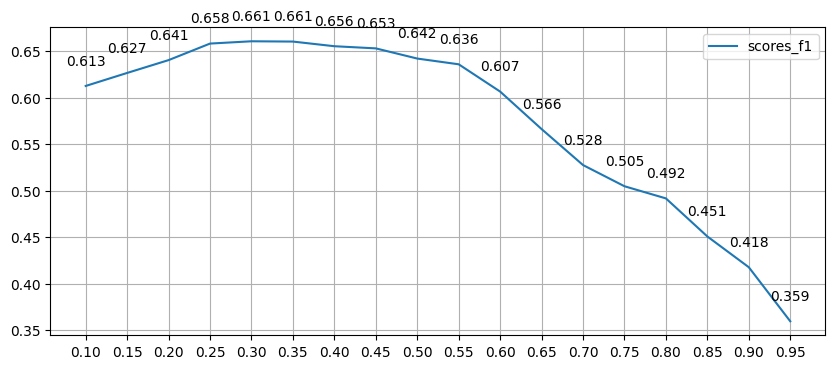

In [19]:
#строим предсказание  для тестовой выборки
y_test_proba_pred = pd.Series(lr_poly.predict_proba(X_test_scaled_poly)[:, 1])
#сразу строим предсказание и для тренировочной выборки
y_train_proba_pred = pd.Series(lr_poly.predict_proba(X_train_scaled_poly)[:, 1])

# Инициализируем список, куда будем сохранять метрику.
scores_f1 = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test,y_test_pred_poly)
    # Добавляем результат в список
    scores_f1.append(score)
fig, ax=plt.subplots(figsize=(10,4))
ax.plot(thresholds,scores_f1, label='scores_f1')
plt.xticks(thresholds)
plt.grid(axis='both')
for xa,ya in zip(thresholds,scores_f1):

    label = "{:.3f}".format(ya)

    plt.annotate(label, # this is the text
                 (xa,ya), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cente
ax.legend()
#Максимальная величина F1 достигается при пороге вероятности 0,3

#Задаём оптимальный порог вероятностей
threshold_opt = 0.35

y_pred_opt_train = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_pred_opt_test = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрику
print('Расчет метрики для тренировочной выборки')
print(metrics.classification_report(y_train, y_pred_opt_train))
print('Расчет метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_pred_opt_test))


После нахождения оптимального порога вероятности удалось еще на несколько процентов увеличить целевую метрику.
В целом правильно подобранная последовательность преобразований (В нашем случае:шкалирование, добавление полиноминальных признаков и нахождение оптимального порога вероятности) способна увеличить метрику на десятки процентов.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))



Train shape: (1881, 13)
Test shape: (628, 13)


Импортируем необходимые для выполнения практики модули:

In [21]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy',
    
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X_train, y_train)
#Делаем предсказания для тренировочной и тестовой выборок
y_tree_train=dt_clf_2d.predict(X_train)
y_tree_test=dt_clf_2d.predict(X_test)


print('Расчет метрики для тренировочной выборки')
print(metrics.classification_report(y_train, y_tree_train))
print('Расчет метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_tree_test))

Расчет метрики для тренировочной выборки
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

Расчет метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       424
           1       0.60      0.61      0.60       204

    accuracy                           0.74       628
   macro avg       0.71      0.71      0.71       628
weighted avg       0.74      0.74      0.74       628



> Модель переобучена так как для тренировочной выборки значениие F-1 равно 1 и выше чем для тестовой выборки(Хотя значения для тестовой выборки неплохие особенно для класса й). Возможно это происходит потому что не ограничена длина дерева и модель слишком идеально подстраивается под тренировочную выборку. 

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d_cut = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d_cut.fit(X_train, y_train)
#Делаем предсказания для тренировочной и тестовой выборок
y_tree_train_cut=dt_clf_2d_cut.predict(X_train)
y_tree_test_cut=dt_clf_2d_cut.predict(X_test)


print('Расчет метрики для тренировочной выборки')
print(metrics.classification_report(y_train, y_tree_train_cut))
print('Расчет метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_tree_test_cut))

Расчет метрики для тренировочной выборки
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1271
           1       0.80      0.65      0.71       610

    accuracy                           0.83      1881
   macro avg       0.82      0.78      0.80      1881
weighted avg       0.83      0.83      0.83      1881

Расчет метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       424
           1       0.73      0.59      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.79      0.80      0.79       628



> Вместе с ограничением дерева улучшился результат.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
rf_clf_2d_forest = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    max_leaf_nodes=10, #число объектов в листе
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d_forest.fit(X_train, y_train)

#Делаем предсказания для тренировочной и тестовой выборок
y_tree_train_forest=rf_clf_2d_forest.predict(X_train)
y_tree_test_forest=rf_clf_2d_forest.predict(X_test)


print('Расчет метрики для тренировочной выборки')
print(metrics.classification_report(y_train, y_tree_train_forest))
print('Расчет метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_tree_test_forest))

Расчет метрики для тренировочной выборки
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1271
           1       0.83      0.55      0.66       610

    accuracy                           0.82      1881
   macro avg       0.82      0.75      0.77      1881
weighted avg       0.82      0.82      0.81      1881

Расчет метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       424
           1       0.76      0.52      0.62       204

    accuracy                           0.79       628
   macro avg       0.78      0.72      0.74       628
weighted avg       0.79      0.79      0.78       628



> По сравнению с деревом решений, лес выдал немного худший результата. На тестовой выборке лес предсказал класс 0 с такой же точностью как дерево решения(0.86 vs 0.86) и несколько ухудшил предсказание метрики f1 по классу 1(0.62 vs 0.66).
Следовательно лес не всегда работает лучше , чем дерево и при исследованиях нужно рассматривать разные модели.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

0.6558265582655826
Расчет метрики для тренировочной выборки
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1271
           1       0.80      0.65      0.71       610

    accuracy                           0.83      1881
   macro avg       0.82      0.78      0.80      1881
weighted avg       0.83      0.83      0.83      1881

Расчет метрики для тестовой выборки
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       424
           1       0.73      0.59      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.79      0.80      0.79       628



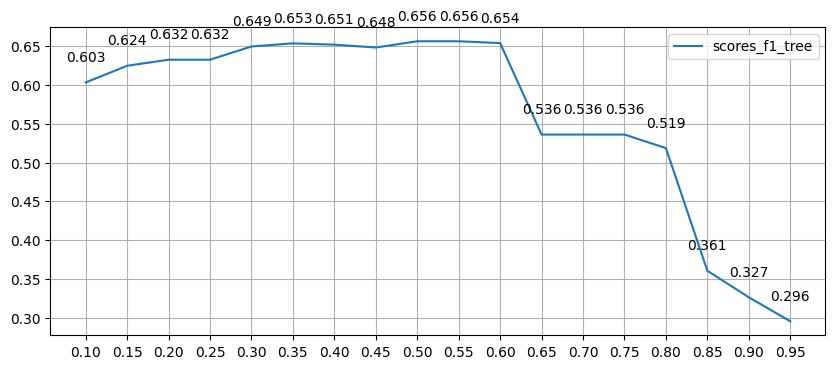

In [25]:
# #строим предсказание  для тестовой выборки
y_test_proba_tree = pd.Series(dt_clf_2d_cut.predict_proba(X_test)[:, 1])
#сразу строим предсказание и для тренировочной выборки
y_train_proba_tree = pd.Series(dt_clf_2d_cut.predict_proba(X_train)[:, 1])

# Инициализируем список, куда будем сохранять метрику.
scores_f1_tree = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_tree = y_test_proba_tree.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test,y_test_pred_tree)
    # Добавляем результат в список
    scores_f1_tree.append(score)
fig, ax=plt.subplots(figsize=(10,4))
ax.plot(thresholds,scores_f1_tree, label='scores_f1_tree')
plt.xticks(thresholds)
plt.grid(axis='both')
for xa,ya in zip(thresholds,scores_f1_tree):

    label = "{:.3f}".format(ya)

    plt.annotate(label, # this is the text
                 (xa,ya), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cente
ax.legend()
print(max(scores_f1_tree))
#Максимальная величина F1 достигается при пороге вероятности 0,3

#Задаём оптимальный порог вероятностей
threshold_opt = 0.5

y_pred_opt_tree_train = y_train_proba_tree.apply(lambda x: 1 if x > threshold_opt else 0)
y_pred_opt_tree_test = y_test_proba_tree.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрику
print('Расчет метрики для тренировочной выборки')
print(metrics.classification_report(y_train, y_pred_opt_tree_train))
print('Расчет метрики для тестовой выборки')
print(metrics.classification_report(y_test, y_pred_opt_tree_test))

> При оптимальном пороге вероятности 0,5 получились наилучшие показатели метрики F1.0.86 для нулевой группыи 0,66 для 1 группы  на тестовой метрике.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [26]:
'''В нашем случае масштабировать и создавать полиноминальные признаки не нужно т.к. 
лучше всего в предсказаниях себя показала модель дерева решений
'''

vasily={
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}# Ваш код здесь
#X_train.info()
vasily_df=pd.DataFrame(vasily)
vasily_df['BalanceSalaryRatio']=vasily_df['Balance']/vasily_df['EstimatedSalary']
vasily_df['TenureByAge']=vasily_df['Tenure']/vasily_df['Age']
vasily_df['CreditScoreGivenAge']=vasily_df['CreditScore']/vasily_df['Age']
vasily_df['Gender_Female']=0
vasily_df['Gender_Male']=1
vasily_df=vasily_df.drop('Gender',axis=1)


print(dt_clf_2d_cut.predict_proba(vasily_df))
print(dt_clf_2d_cut.predict(vasily_df))

[[0.11111111 0.88888889]]
[1]


Вероятность принадлежности к классу один для Василия 0,89.